# Classification of retina images - normal and pathological

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

# Loading the DR_2000 images for analysis 

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Jan 24 02:43 kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets list -s DR_2000


ref              title    size  lastUpdated          downloadCount  
---------------  -------  ----  -------------------  -------------  
zhizhid/dr-2000  DR_2000   2GB  2019-08-31 23:30:36            658  


In [ ]:
!kaggle datasets download -d zhizhid/dr-2000 --force

 99% 1.88G/1.90G [00:12<00:00, 146MB/s]
100% 1.90G/1.90G [00:12<00:00, 162MB/s]


In [ ]:
!unzip dr-2000.zip -d DR_2000

In [ ]:
!ls

DR_2000  dr-2000.zip  kaggle.json  sample_data


In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Training ResNet34 with Image size = 64X64 

In [ ]:
path ="./DR_2000/data/"
bs = 100

# using the ImageDataBunch to load the images 

### did not apply any additional image transformation 
data = ImageDataBunch.from_folder(path, 
                                  ds_tfms=get_transforms(),
                                  valid_pct=0.2, 
                                  size=64, 
                                  bs=bs)

In [ ]:
# sanity checks 
data

ImageDataBunch;

Train: LabelList (1600 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
normal,normal,normal,normal,normal
Path: DR_2000/data;

Valid: LabelList (400 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
normal,dr,dr,dr,dr
Path: DR_2000/data;

Test: None

In [ ]:
# just making sure I got both classes
data.train_ds.classes

['dr', 'normal']

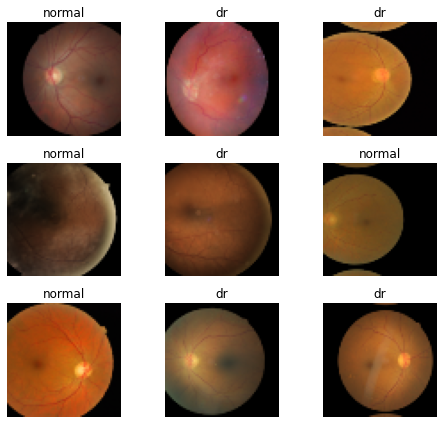

In [ ]:
data.show_batch(rows=3, figsize=(7,6))


## Training: resnet34

This model was in the notebook from fast ia -> so I run it as well

In [ ]:
# loading pretrain model 
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.173373,0.911937,0.437500,03:25
1,1.132198,0.948434,0.507500,03:24
2,1.093841,0.831338,0.482500,03:25
3,1.027935,0.800342,0.447500,03:25


In [ ]:
### just in case saving it if tunning will not work good  
learn.save('stage-1')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

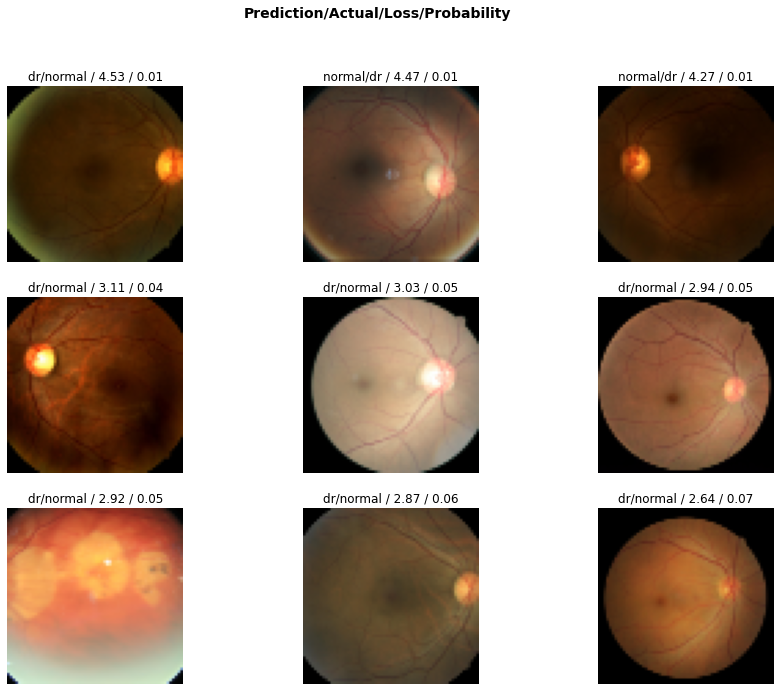

In [ ]:
interp.plot_top_losses(9, figsize=(15,11))
# unfortunatly I do not remember the symptoms of the Diabetic retina exept the mini white 
#spots on it and hemorrage, however, some of the images are dark, so lightening of them may not hurt-> will implement it late. 
#However some of them are super bright   

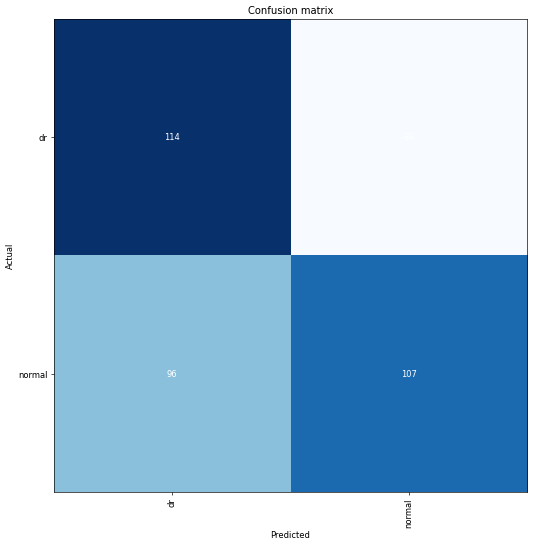

In [ ]:
interp.plot_confusion_matrix(figsize=(9,9), dpi=60)

In [ ]:
interp.most_confused(min_val=2)

[('normal', 'dr', 96), ('dr', 'normal', 83)]

Our model does not peroform very good. However we can improve the error rate by unfrezeening the model layers, augment images, find a good learning rate, use deeper model.  

### Unfreezing

In [ ]:
### unfreezing the model and running over 3 cycles 
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.992772,0.905439,0.452500,03:24


###Learning rate 

We unfreeze model -> lets use learning rate finder, to see how we can improve the model.

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


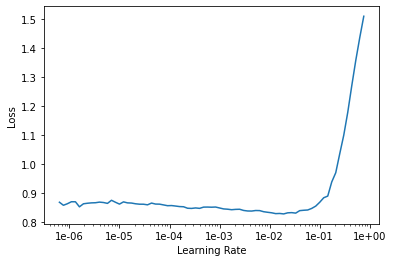

In [ ]:
learn.recorder.plot()

We have to keep our losses to minimum -> means the best values would be before the 1e-01, since the loss is increasing right before this value 

In [ ]:
learn.fit_one_cycle(5, max_lr=slice(1e-04,1e-02))


epoch,train_loss,valid_loss,error_rate,time
0,0.855474,0.774509,0.477500,03:25
1,0.823760,1.108911,0.470000,03:25
2,0.827871,1.325130,0.397500,03:28
3,0.807680,0.704991,0.405000,03:26
4,0.784157,0.665086,0.402500,03:26


Looks like learning rate helped, we improve approximatly error rate for 7%. 

Lets increase the depht of the model and use resnet50, apply some audmentation of the images and normalize the images. 

## Training: resnet50
#### size 128 (increase the size of image), applied image augmentation   

In [ ]:
path ="./DR_2000/data/"

data = ImageDataBunch.from_folder(path, 
                                  ds_tfms=get_transforms(do_flip=True, flip_vert=True, 
                                                         max_lighting =0.3,               
                                                         max_zoom=1.2,
                                                         max_rotate=25,
                                                         p_lighting=0.95
                                                         ),
                                  valid_pct=0.2, 
                                  size=128, 
                                  bs=64).normalize(imagenet_stats)

In [ ]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate).to_fp16()
# apply to_fp16()- mixed precision training - to increase the speed of training -> may suffer form it later 

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.404770,1.326807,0.390000,03:51
1,1.228194,0.848244,0.395000,03:40
2,1.041593,0.686583,0.372500,03:41
3,0.891855,0.663227,0.375000,03:43


In [ ]:
# lets unfreese the model 
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.718608,0.748965,0.400000,03:44


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


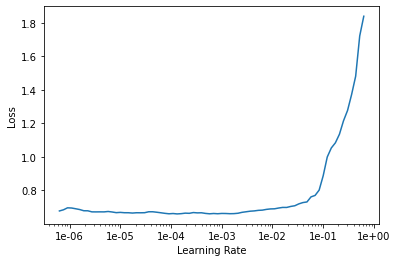

In [ ]:
### lest look at the learning rate and find good one
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-05,1e-02)) 
# taking the 'middle' slice

epoch,train_loss,valid_loss,error_rate,time
0,0.727183,0.667119,0.372500,03:39
1,0.754714,0.697903,0.412500,03:42
2,0.761787,0.666912,0.335000,03:40
3,0.712207,0.608512,0.325000,03:40


we close to error rate to drop bellow 30 -> but not there yet.

Time to increse the image size to 224X224.

Unfortunately, I could not find how to do it in fast ai without loading the data again, so bear with me for now.  

#### increase the image size to 224 

In [ ]:
data2 = ImageDataBunch.from_folder(path, 
                                  ds_tfms=get_transforms(do_flip=True,
                                                         flip_vert=True, 
                                                         max_rotate=25,
                                                         max_lighting =0.3,               
                                                         max_zoom=1.2,                                                                                                                 
                                                        p_lighting=0.95),
                                  valid_pct=0.2, 
                                  size=224, 
                                  bs=100).normalize(imagenet_stats)
learn2 = cnn_learner(data2, models.resnet50, metrics=error_rate).to_fp16()

 This time lets run more cycles 

In [ ]:
learn2.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.218328,0.966364,0.420000,03:34
1,1.220764,1.061466,0.342500,03:36
2,1.131243,0.734343,0.332500,03:35
3,0.984567,0.623756,0.345000,03:35
4,0.877614,0.633977,0.337500,03:36
5,0.797428,0.595829,0.315000,03:34
6,0.749158,0.589882,0.315000,03:35
7,0.709994,0.591151,0.310000,03:35


I am satisfy with the error rate for now-> let try to unfreeze the model -> may be it will help 

In [ ]:
learn2.save('stage50-2') # just in case saving model if the unfreezing will not help

In [ ]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.most_confused(min_val=2)


[('dr', 'normal', 68), ('normal', 'dr', 56)]

In [ ]:
learn2.unfreeze()

In [ ]:
learn2.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.715733,0.851109,0.405000,03:38


In [ ]:
### lets looked into the learning rate 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


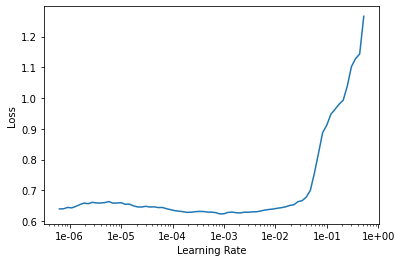

In [ ]:
learn2.lr_find()
learn2.recorder.plot()

In [ ]:
learn2.fit_one_cycle(4, max_lr=slice(1e-4, 1e-2) ) 
# decided to take this slice -> since it is minimal at the graphic above

epoch,train_loss,valid_loss,error_rate,time
0,0.709229,3.110304,0.412500,03:36
1,0.697820,41.949528,0.440000,03:36
2,0.661443,1.002656,0.425000,03:36
3,0.624479,0.589684,0.322500,03:38


### Resnet101 with same augmentation parameters 

In [ ]:
data3 = ImageDataBunch.from_folder(path, 
                                  ds_tfms=get_transforms(do_flip=True, flip_vert=True, 
                                                         max_rotate=25,
                                                         max_lighting =0.3,               
                                                         max_zoom=1.2,  
                                                        p_lighting=0.95),
                                  valid_pct=0.2, 
                                  size=224, 
                                  bs=32).normalize(imagenet_stats)
learn = cnn_learner(data3, models.resnet101, metrics=error_rate).to_fp16()

In [ ]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.493635,1.280349,0.385000,03:39
1,1.077470,0.705810,0.362500,03:39
2,0.827367,0.635176,0.322500,03:38
3,0.720259,0.614668,0.330000,03:37


In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.765649,0.657835,0.367500,03:39


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


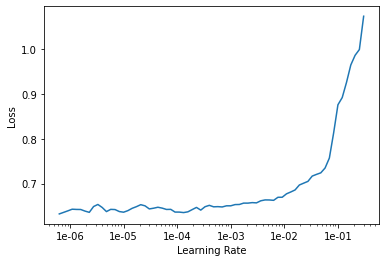

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(8, max_lr=slice(1e-6, 1e-2))  
 

epoch,train_loss,valid_loss,error_rate,time
0,0.706444,0.763530,0.430000,03:43
1,0.736601,0.809147,0.325000,03:41
2,0.746633,0.708778,0.367500,03:41
3,0.774500,0.816690,0.362500,03:40
4,0.712361,0.623706,0.305000,03:44
5,0.645809,0.603767,0.297500,03:40
6,0.590129,0.585267,0.285000,03:40
7,0.568326,0.580932,0.290000,03:42


the error rate below 30% 
